# DU IA et Santé - Atelier NLP

Dans cet atelier, nous allons voir plusieurs techniques de NLP "moderne", principalement basées sur les transformers et la librairie [huggingface](https://huggingface.co/).

Cet atelier est diviser en trois partie.

Dans la partie 1, nous allons nous intéresser à la partie encodage des transformers (BERT et cie.) afin de mieux comprendre les représentations internes de ceux-ci.

Dans la partie 2, nous interesserons à la partie decodage des transformers (GPT et cie.) et aux méthodes de *prompt engineering* permettant d’améliorer leurs résultats.

Enfin, dans la partie 3, nous allons voir comment méler les deux approches pour construire des assistants personnels.

Mais, avant toute choses, il nous faut installer quelques librairies.

Pour cela, executez la cellule suivante:

In [ ]:
!pip install accelerate jupyter-scatter

Puis, nous allons importer quelques librairies et vérifier que nous accédons bien au GPU (si vous en avez un).

Pour cela exécutez la cellule ci-dessous.

In [1]:
# Librairies utilitaires
from tqdm.auto import tqdm
import ipywidgets
import gc

# Librairies mathématiques
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
import jscatter

# Librairies ML
import torch
print("cuda available?", str(torch.cuda.is_available()))
device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  torch.cuda.set_device(device)
  print("cuda version:", torch.version.cuda)
  print("cuDNN enabled?", torch.backends.cudnn.enabled)
  print("cuDNN version:", torch.backends.cudnn.version())
  print("Device name? ", torch.cuda.get_device_name(torch.cuda.current_device()))

# Initialisation générateurs de nombres aléatoires
SEED = 42
np.random.seed(SEED)
torch.random.manual_seed(SEED)

cuda available? True
cuda version: 12.1
cuDNN enabled? True
cuDNN version: 8902
Device name?  Tesla T4


Si le résultat est : `cuda available? False`, cela signifie que la librairie *torch* n’a pas pu accéder à votre GPU.

Dans le cas contraire (ou si vous n’avez pas de GPU à disposition), nous pouvons passer à la suite.

remarque: si vous utiliser ce GoogleCollab, cliquez sur Exécution > Modifier le type d’exécution et séléctionnnez l’option T4 GPU

## Partie 1 - Encodage et représentations internes

Dans cette partie, nous allons voir comment les transformers, plus spécifiquement les modèles de type BERT, encodent et transforment les textes fournis pour les donner en entrée des modèles. Nous allons aussi étudier les représentations internes de ce modèles, leurs espaces latents, et comment manipuler ces réprésentations.

Pour cela, nous allons nous baser sur le modèle [CamemBERT](https://camembert-model.fr/), entrainé sur des textes en français.

Pour essayer un autre modèle, voir: https://huggingface.co/models (par exemple: sentence-transformers/all-MiniLM-l6-v2)

In [2]:
from transformers import CamembertModel, CamembertTokenizer

model_name = "camembert/camembert-base"

model = CamembertModel.from_pretrained(model_name, device_map=device, torch_dtype="auto")
tokenizer = CamembertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### 1.1 Tokenization et encodage

La première étape pour permettre à un modèle de language de traiter du texte est la tokenisation.

Cette étape permet de découper une phrase ou un mot en un ou plusieurs *token* connus du modèle (l’ensemble des tokens connus par un modèle est appelé son "vocabulaire").

Par exemple:

In [3]:
sentence = "fromage"
tokenized_sentence = tokenizer.tokenize(sentence)
tokenized_sentence

['▁fromage']

Cependant, un modèle attend en entrée non pas une liste de tokens, mais la liste des id correspondant à ces tokens dans son vocabulaire.

Ainsi, il nous faut encoder les tokens obtenus précédemment en une liste d’entier utilisable par le modèle.

In [4]:
encoded_sentence = tokenizer.encode(tokenized_sentence, return_tensors="pt")
encoded_sentence

tensor([[   5, 5271,    6]])

Le résultat ci-dessus présente la liste des ids correspondant aux tokens de notre phrase.

Nous pouvons cependant noter la précense de deux ids supplémentaires (5 et 6), ceux-ci correspondants aux tokens de début et fin de phrase.

Sentez-vous libre de modifier la phrase d’exemple avant de passer à la suite.

### 1.2 Word Embeddings et espaces latents

Maintenant que nous avons comment tokeniser et encoder un texte pour permettre à un modèle de manipuler ce texte, nous allons voir les réprentations internes utilisé par ces modèles pour manipuler ces textes.

Pour cela nous allons utiliser la classe *pipeline* de la librairie *transformers*.

In [5]:
from transformers import pipeline

Cette classe permet d’utiliser nos modèles sur divers problèmes.

Ici, nous allons l’utiliser pour effectuer de la *feature-extraction* et ainsi obtenir les représentations interne des phrases fournies à notre modèle.

In [6]:
pipeline = pipeline('feature-extraction', model=model, tokenizer=tokenizer)

Par exemple:

In [7]:
data = pipeline(sentence)
pd.DataFrame(data[0])

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.059190,0.155858,0.158741,-0.154770,-0.071912,0.009426,0.054055,0.147159,-0.004983,0.027380,...,-0.130098,-0.030714,-0.104412,0.121723,-0.008207,0.053603,0.090126,-0.039277,-0.013562,-0.073203
1,0.012923,0.098028,0.146422,-0.134837,-0.014562,0.036237,0.038793,0.199658,0.003588,0.054137,...,-0.111312,-0.034702,-0.213986,0.150479,-0.059385,0.047653,0.138099,-0.076688,0.019717,-0.051448
2,-0.067307,-0.066881,-0.068151,0.082117,0.041438,0.030563,-0.174897,0.112619,0.084024,-0.013139,...,-0.157657,0.152825,-0.177257,-0.019118,0.066282,-0.023974,-0.091324,-0.029913,0.067913,0.093924


In [8]:
pd.DataFrame([np.array(data[0]).mean(axis=0)])

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.037858,0.062335,0.079004,-0.069164,-0.015012,0.025409,-0.027349,0.153145,0.027543,0.022792,...,-0.133022,0.029136,-0.165218,0.084361,-0.000436,0.025761,0.045633,-0.048626,0.024689,-0.010242


Nous voyons ici, que notre modèle transforme chaque token de notre phrase en vecteurs de taille:

In [9]:
len(data[0][1])

768

La taille de ces vecteurs, générallement appellés *embeddings*, determine le nombre de dimensions de l’espace latent de notre modèle.

Chaque vecteur correspondant alors à un point dans cet espace.

Il est alors possible d’avoir un aperçu du vocabulaire d’un modèle dans son espace latent.

Pour cela, il nous faut dans un premier temps recupérer les embeddings de chaque token présent dans le vocabulaire d’un modèle.

In [52]:
# On récupère le vocabulaire du modèle
vocab = [token.replace("▁", "") for token in list(tokenizer.get_vocab().keys())]

# On encodage le vocabulaire
embedded_vocab = pipeline(vocab, batch_size=32)

# On met le résultat sous un format plus facile à utiliser
df_embedded_vocab = pd.DataFrame([np.array(ev[0]).mean(axis=0) for ev in embedded_vocab], index=vocab)

# On affiche le résultat
df_embedded_vocab

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
<s>NOTUSED,-0.025244,0.093723,0.125123,-0.138833,-0.064492,0.036315,0.013145,0.141634,0.001115,0.037957,...,-0.112450,-0.024348,-0.148170,0.155215,-0.030634,0.070252,0.137488,-0.063678,-0.013932,-0.039471
<pad>,-0.032208,0.055006,0.146801,-0.102222,-0.054902,0.071757,0.011371,0.125129,0.007894,0.015854,...,-0.095499,0.037695,-0.085322,0.164811,0.016258,0.043511,0.047785,-0.007045,0.023991,-0.077703
</s>NOTUSED,-0.039337,0.070124,0.143554,-0.087114,-0.036450,0.056317,0.020786,0.131796,0.024679,0.006291,...,-0.114036,0.029715,-0.093260,0.135393,-0.009938,0.044022,0.036371,-0.021763,0.011898,-0.032926
<unk>,-0.017544,0.036689,0.036849,-0.036657,-0.017606,0.046519,-0.053903,0.107329,0.013729,0.033644,...,-0.126138,0.072830,-0.133483,0.129334,-0.000197,0.032584,0.020063,-0.021379,0.066654,-0.038613
<unk>NOTUSED,-0.011003,0.039306,0.071180,-0.034182,-0.008755,0.048076,-0.017356,0.133847,0.042711,0.029709,...,-0.123676,0.078761,-0.107264,0.124654,0.037485,0.033166,0.004693,-0.009260,0.039407,-0.025824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
atteigne,0.003740,0.039268,0.091475,-0.049881,-0.009931,0.036334,-0.007397,0.126170,0.039189,0.035567,...,-0.104140,0.046253,-0.111425,0.115189,0.028251,0.039249,0.021380,0.006673,0.031728,-0.010895
REUTERS,0.043754,0.233327,0.045079,-0.056724,-0.020279,0.049070,-0.032945,0.085641,-0.018487,0.029082,...,-0.069632,-0.031073,-0.078845,0.120235,0.006646,0.026080,0.029489,-0.046075,0.002782,-0.080632
embûches,0.032372,0.274975,0.075025,-0.089763,-0.030577,0.024463,-0.065858,0.074826,0.030633,0.037396,...,-0.069179,-0.026149,-0.086092,0.160933,-0.038633,0.033559,-0.006990,0.013174,0.009226,-0.140970
Administratif,-0.028673,0.050294,0.041574,-0.043943,-0.007647,0.062304,-0.056313,0.104055,0.027278,0.031078,...,-0.147183,0.058001,-0.135990,0.127719,-0.004623,0.028900,0.009044,-0.020769,0.074160,-0.027544


On peut alors récupérer l’embedding d’un token specifique, par exemple:

In [11]:
df_embedded_vocab.iloc[[5271]]

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
fromage,-0.029483,0.026967,0.067272,-0.035334,-0.014817,0.060951,-0.047321,0.116253,0.030473,0.029659,...,-0.12317,0.062941,-0.116509,0.122284,0.028713,0.038642,0.009123,-0.012838,0.061905,-0.01986


In [12]:
from sklearn.decomposition import PCA

In [13]:
pca = PCA(n_components=2)
pca_embedded_vocab = pca.fit_transform(df_embedded_vocab)

In [14]:
df_pca = pd.DataFrame(data = pca_embedded_vocab, columns = ['PC1', 'PC2'], index=vocab)

In [15]:
scatter = jscatter.Scatter(data=df_pca, x="PC1", y="PC2")

output = ipywidgets.Output()

@output.capture(clear_output=True)
def selection_change_handler(change):
  display(df_pca.iloc[change.new])

scatter.widget.observe(selection_change_handler, names=["selection"])

ipywidgets.HBox([scatter.show(), output])

Example de visualisation:

https://projector.tensorflow.org/

https://helboukkouri.github.io/embedding-visualization/

Chaque dimension correspond à un "concept" utilisé par le modèle pour différencier les *tokens* entre eux.

Chaque cellule d’un *embedding* correspond alors à la position, allant de -1 à 1, du token associé sur une des dimensions de l’espace latent du modèle.

Nous pouvons, par exemple, visualiser la position d’un token sur chaque dimension à l’aide d’une *heatmap*.

<Axes: >

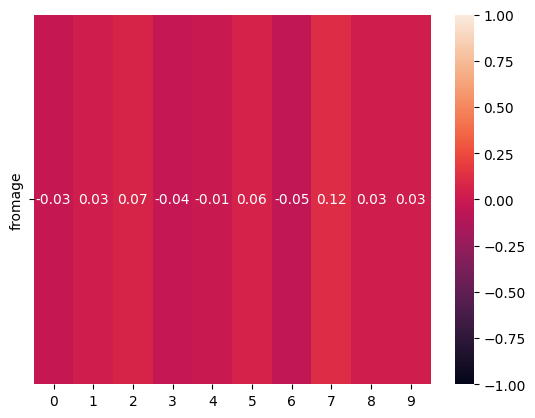

In [16]:
# On commence par convertir notre embedding dans un format plus adapté
df = df_embedded_vocab.iloc[[5271]]

# Et on lance la représentation (des 10 premières valeurs pour plus de lisibilité)
# sous forme de heatmap
sb.heatmap(df.iloc[:, : 10], vmin=-1.0, vmax=1.0, annot=True, fmt=".2f")

In [17]:
### Exemples token proches
from sklearn.metrics.pairwise import cosine_similarity

tst = df_embedded_vocab.iloc[[5271]]

df_tst = pd.DataFrame(cosine_similarity(tst, df_embedded_vocab)[0], columns=["similarity"], index=vocab)
df_tst = df_tst.sort_values(by=['similarity'], ascending=False)

df_tst

,similarity
fromage,1.000000
soupe,0.999516
fromages,0.999471
revient,0.999334
Ticket,0.999262
...,...
édition,0.272276
viens,0.271938
viens,0.271938
devons,0.270490


Voir:

https://degaucheoudedroite.delemazure.fr/

In [61]:
### TODO Exemples math sur vecteur (ROI - HOMME + FEMME)
mot1 = pipeline("France")
mot1 = pd.DataFrame([np.array(mot1[0]).mean(axis=0)])
mot1

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.050523,0.126598,0.180046,-0.139915,-0.075682,0.021821,0.044816,0.143278,0.021173,0.009725,...,-0.113908,-0.026913,-0.119279,0.11716,0.00858,0.0751,0.086271,-0.04593,0.006869,-0.060638


In [62]:
mot2 = pipeline("Paris")
mot2 = pd.DataFrame([np.array(mot2[0]).mean(axis=0)])
mot2

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.046129,0.127649,0.173196,-0.141021,-0.069452,0.018116,0.047732,0.160914,0.021937,0.017908,...,-0.111099,-0.026212,-0.132114,0.123551,-0.011287,0.068273,0.090044,-0.044189,-0.006816,-0.070027


In [67]:
mot3 = pipeline("Berlin")
mot3 = pd.DataFrame([np.array(mot3[0]).mean(axis=0)])
mot3

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.03327,0.072586,0.079739,-0.091313,-0.00056,0.019146,-0.030035,0.154143,0.010012,0.023781,...,-0.130969,0.038165,-0.17857,0.081033,-0.03934,0.025974,0.065326,-0.053037,0.022473,-0.028617


In [68]:
mot1 - mot2 + mot3

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.037664,0.071535,0.086588,-0.090207,-0.006791,0.022851,-0.032951,0.136508,0.009248,0.015598,...,-0.133778,0.037464,-0.165736,0.074642,-0.019473,0.032802,0.061553,-0.054777,0.036159,-0.019228


In [69]:
df_tst = pd.DataFrame(cosine_similarity(mot1 - mot2 + mot3, df_embedded_vocab)[0], columns=["similarity"], index=vocab)
df_tst = df_tst.sort_values(by=['similarity'], ascending=False)

df_tst.iloc[:10]

,similarity
Janeiro,0.996550
sophrologie,0.996392
Voilà,0.996377
brassage,0.996288
sifflet,0.996183
partager,0.996181
globules,0.996159
variateur,0.996130
déductible,0.996069
amis,0.995977


Voir: http://nlp.polytechnique.fr/word2vec

https://neal.fun/infinite-craft/

In [70]:
del embedded_vocab
del df_embedded_vocab
del vocab
gc.collect()

31

Pour en savoir plus sur le fonctionnement des embeddings, voir: https://jalammar.github.io/illustrated-word2vec/

### 1.3 Sauvegarde et recherche sémantique de documents

In [24]:
data = pipeline("J'aime le fromage")
pd.DataFrame(data[0])

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.087094,0.061525,0.125109,-0.141805,-0.081726,-0.027691,0.012860,0.191857,0.030472,0.041560,...,-0.083819,-0.095209,-0.050811,0.155444,0.045074,0.071799,0.038059,-0.075018,-0.111487,-0.099079
1,-0.023309,0.020311,0.116542,-0.115306,-0.027890,0.004252,-0.010070,0.237664,0.028730,0.062341,...,-0.073087,-0.101643,-0.162375,0.182540,-0.004025,0.066046,0.095212,-0.121712,-0.065501,-0.069980
2,-0.146877,-0.118539,0.246399,0.097881,-0.116056,-0.130248,-0.068884,-0.093908,0.088209,0.054613,...,-0.071852,0.305064,0.012968,0.053521,0.058241,-0.088962,0.045969,-0.051419,-0.018374,0.007036
3,0.149559,-0.281240,0.012493,0.006587,-0.066077,-0.243776,0.012462,-0.076969,-0.086428,0.227882,...,0.054458,-0.170853,0.234021,-0.012546,0.117257,-0.048061,-0.038553,0.000699,0.044253,-0.069940
4,-0.112006,0.002611,0.126574,0.024079,0.005259,-0.106453,-0.039901,-0.016848,-0.161606,0.052934,...,-0.028674,-0.269085,-0.055837,0.099677,0.179588,0.019454,0.056591,-0.114411,-0.134906,0.019771
5,-0.025575,-0.200331,0.238823,-0.117565,-0.007521,0.081868,-0.128649,0.044235,-0.022322,0.049085,...,-0.011093,-0.091455,0.092721,0.114986,0.262241,0.046750,0.025709,0.107999,-0.027339,-0.054196
6,-0.010182,-0.115175,-0.093351,-0.033284,-0.053034,0.025216,-0.098808,-0.038637,-0.031431,-0.007947,...,-0.049227,-0.133091,0.183731,-0.093608,0.151176,0.150180,0.094594,0.094309,-0.092110,-0.118594


In [34]:
data1 = pipeline("J'aime le fromage",return_tensors = "pt")[0].numpy().mean(axis=0)
data1 = pd.DataFrame([data1])
data1

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.036498,-0.09012,0.11037,-0.039916,-0.049578,-0.05669,-0.045856,0.035342,-0.022054,0.068638,...,-0.037614,-0.079467,0.036345,0.071431,0.11565,0.031029,0.045369,-0.022793,-0.057923,-0.054997


In [35]:
data2 = pipeline("Je déteste le fromage",return_tensors = "pt")[0].numpy().mean(axis=0)
data2 = pd.DataFrame([data2])
data2

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.014298,-0.005238,0.071897,-0.10531,-0.037936,-0.069946,-0.04128,0.04898,-0.009072,0.022493,...,-0.09235,-0.196737,0.047275,0.051533,0.137609,0.047403,0.041675,-0.011768,-0.075672,-0.074446


In [36]:
data3 = pipeline("La Tomme de Savoie c'est vraiment bon", return_tensors = "pt")[0].numpy().mean(axis=0)
data3 = pd.DataFrame([data3])
data3

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.002367,0.044256,0.001642,0.012856,-0.023886,-0.017957,0.023941,0.052179,-0.040629,0.130111,...,-0.000545,0.081752,0.012296,-0.027343,0.038851,0.034791,0.059237,-0.064125,-0.036973,0.037867


In [45]:
data4 = pipeline("Le soleil brille sur la ville de Paris aujourd'hui", return_tensors = "pt")[0].numpy().mean(axis=0)
data4 = pd.DataFrame([data4])
data4

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.036832,0.112162,-0.072491,0.060334,0.032409,-0.009211,0.003369,0.012513,0.018274,0.193073,...,0.036387,0.075572,-0.009268,-0.049853,0.13547,-0.021227,-0.044248,0.008513,-0.050746,-0.016144


In [40]:
cosine_similarity(data1, data2)

array([[0.9482939]], dtype=float32)

In [41]:
cosine_similarity(data1, data3)

array([[0.8493474]], dtype=float32)

In [46]:
cosine_similarity(data1, data4)

array([[0.7659543]], dtype=float32)

In [123]:
bdd_embeddings = pd.DataFrame(columns=data1.columns)
bdd_texts = []

def store_text_embeddings(text):
  if not text in bdd_texts:
    embeddings = pipeline(text, return_tensors = "pt")[0].numpy().mean(axis=0)
    bdd_embeddings.loc[len(bdd_embeddings.index)] = embeddings
    bdd_texts.append(text)

In [124]:
texts = [
"Camembert est une appellation générique qui désigne généralement un fromage à pâte molle et à croûte fleurie. Commercialement, cette appellation d'origine normande ne fait l'objet d'aucune protection et se voit utilisée pour des fromages n'ayant parfois que peu de rapport avec le camembert originel. Dans certaines régions de France, le camembert est appelé « claquos », « clacos », « calendos ».",
"Le bleu d’Auvergne est un fromage à pâte persillée fabriqué en France dans le Massif central à partir de lait de vache. Son persillage allant du bleu au bleu noir. Son appellation d'origine bénéficie de protections depuis 1975.",
"La tomme de Savoie est un fromage produit en France dans la région alpine de Savoie, regroupant les départements de la Savoie et de la Haute-Savoie. Son appellation est protégée par une indication géographique protégée.",
"Le munster ou munster-géromé (ou encore Minschterkäs en francique lorrain ou Minschterkaas en alsacien) est un fromage à pâte molle fabriqué à partir de lait de vache dans l'Est de la France. Son appellation est protégée nationalement depuis 1969 par une appellation d'origine contrôlée (AOC) et dans l'ensemble des pays de l'Union européenne depuis 1996 par une appellation d'origine protégée (AOP).",
"Les bries sont une famille de fromages à pâte molle à croûte fleurie, originaire de la région française de Brie.",
"L’emmentaler ou emmental est un fromage d'origine suisse à pâte dure dont le nom provient de la vallée de l'Emme (en allemand, Emmental), une région à l'est du canton de Berne.",
"Le gorgonzola est l'appellation d'origine d'un fromage traditionnel à base de lait de vache, à pâte persillée, fabriqué dans les régions de Lombardie et du Piémont.",
"Le Valençay est une appellation d'origine désignant un fromage de chèvre au lait cru du Berry, et de la région Centre-Val de Loire, en France. Elle reprend le nom de la commune homonyme.",
"Le saint-marcellin IGP est un fromage français du Dauphiné. Son Indication géographique protégée (IGP) date de la fin 2013, elle s'étend sur 274 communes en Isère, dans la Drôme et en Savoie.",
"Reblochon ou reblochon de Savoie est une appellation d'origine désignant un fromage français produit principalement en Haute-Savoie et dans quelques communes de Savoie. Cette appellation est originaire du massif des Bornes et des Aravis, principalement la vallée de Thônes, et s'est étendue au val d'Arly et au massif des Bauges."
]

for text in texts:
  store_text_embeddings(text)

In [125]:
bdd_embeddings

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.047184,0.060954,-0.092554,0.103450,0.003643,-0.091576,0.005704,0.063387,0.000759,0.127298,...,0.037307,0.010078,0.014331,-0.063568,0.060658,-0.010753,-0.006031,-0.051982,0.005604,0.017386
1,0.046042,0.042845,-0.065178,0.061454,-0.008315,-0.041558,0.012288,0.018745,-0.011604,0.080475,...,0.003708,0.009313,0.011189,-0.015238,0.067214,0.005887,0.010818,-0.022224,0.028093,0.022138
2,-0.004655,0.125877,-0.026906,0.067365,-0.001282,-0.084862,0.012218,0.035239,-0.012478,0.117365,...,0.001103,0.045541,-0.032832,-0.019284,0.022460,0.010342,-0.042443,-0.070692,-0.007880,0.052317
3,0.070323,0.041820,-0.106699,0.113552,-0.013805,-0.054767,-0.007536,0.024169,-0.006089,0.134784,...,0.006889,0.045519,-0.003371,-0.129055,0.040882,-0.000328,0.011854,-0.048704,0.011546,-0.004586
4,0.074546,0.078724,0.040282,0.061543,-0.018543,-0.113074,0.026214,0.077257,0.026506,0.091214,...,0.035924,0.016469,0.018887,-0.049377,0.016470,0.037080,-0.010591,-0.058977,0.026896,-0.037399
5,-0.012333,-0.059545,0.046591,0.062886,-0.017732,-0.094449,0.001697,0.028755,-0.000068,0.111721,...,-0.006453,0.081949,-0.069176,-0.025469,0.079276,-0.002128,0.028067,-0.056117,-0.002248,-0.024872
6,0.005561,-0.033665,0.033208,0.110371,0.020790,-0.080835,0.014782,0.002516,-0.001504,0.104867,...,0.017108,0.035465,-0.047212,-0.043560,0.064317,0.030867,-0.003203,-0.050687,0.034716,-0.024605
7,0.035098,0.056147,0.005002,0.076149,0.015928,-0.053606,0.006407,0.031678,0.012896,0.081556,...,0.005927,0.031987,-0.015656,-0.070349,0.051755,0.007919,-0.024402,-0.069042,0.007350,0.023609
8,0.040850,0.110905,-0.053778,0.088578,-0.006955,-0.045109,-0.019544,0.053189,0.014332,0.093073,...,-0.013402,0.066684,0.006127,-0.043039,0.018144,0.009560,0.005359,-0.054570,0.005455,0.073558
9,0.002541,0.076237,-0.004907,0.111402,-0.008803,-0.040822,-0.008784,0.042229,-0.013822,0.103492,...,0.008542,0.060099,-0.037480,-0.024946,0.012715,0.014119,-0.036065,-0.047367,-0.002420,0.072387


In [126]:
bdd_texts

["Camembert est une appellation générique qui désigne généralement un fromage à pâte molle et à croûte fleurie. Commercialement, cette appellation d'origine normande ne fait l'objet d'aucune protection et se voit utilisée pour des fromages n'ayant parfois que peu de rapport avec le camembert originel. Dans certaines régions de France, le camembert est appelé « claquos », « clacos », « calendos ».",
 "Le bleu d’Auvergne est un fromage à pâte persillée fabriqué en France dans le Massif central à partir de lait de vache. Son persillage allant du bleu au bleu noir. Son appellation d'origine bénéficie de protections depuis 1975.",
 'La tomme de Savoie est un fromage produit en France dans la région alpine de Savoie, regroupant les départements de la Savoie et de la Haute-Savoie. Son appellation est protégée par une indication géographique protégée.',
 "Le munster ou munster-géromé (ou encore Minschterkäs en francique lorrain ou Minschterkaas en alsacien) est un fromage à pâte molle fabriqué

In [127]:
def find_documents(query, nresults=5):
  query_embeddings = pd.DataFrame([pipeline(query, return_tensors = "pt")[0].numpy().mean(axis=0)])
  df = pd.DataFrame(cosine_similarity(query_embeddings, bdd_embeddings)[0], columns=["similarity"])
  df = df.sort_values(by=['similarity'], ascending=False)

  indexes = df.iloc[:nresults].index

  results = []
  for i in indexes:
    results.append({"doc": bdd_texts[i], "score": df.iloc[i]["similarity"]})

  return results

In [129]:
query = """
Fromage de Savoie
"""

find_documents(query)

[{'doc': 'Les bries sont une famille de fromages à pâte molle à croûte fleurie, originaire de la région française de Brie.',
  'score': 0.340503},
 {'doc': "Le saint-marcellin IGP est un fromage français du Dauphiné. Son Indication géographique protégée (IGP) date de la fin 2013, elle s'étend sur 274 communes en Isère, dans la Drôme et en Savoie.",
  'score': 0.18878819},
 {'doc': 'La tomme de Savoie est un fromage produit en France dans la région alpine de Savoie, regroupant les départements de la Savoie et de la Haute-Savoie. Son appellation est protégée par une indication géographique protégée.',
  'score': 0.37143242},
 {'doc': "Le Valençay est une appellation d'origine désignant un fromage de chèvre au lait cru du Berry, et de la région Centre-Val de Loire, en France. Elle reprend le nom de la commune homonyme.",
  'score': 0.21809717},
 {'doc': "Le bleu d’Auvergne est un fromage à pâte persillée fabriqué en France dans le Massif central à partir de lait de vache. Son persillage a

Voir: https://www.trychroma.com/

## Partie 2 - Large modèles de langage et techniques de génération de texte

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

In [ ]:
model_name = "microsoft/Phi-3-mini-128k-instruct"

model = AutoModelForCausalLM.from_pretrained("microsoft/Phi-3-mini-128k-instruct", device_map=device, torch_dtype="auto", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-128k-instruct")


In [ ]:
messages = [
    {"role": "user", "content": "Qu'est qu'un cathéter et comment l'utiliser ?"},
]

In [ ]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

In [ ]:
generation_args = {
    "max_new_tokens": 500,
    "return_full_text": False,
    "do_sample": False,
    # pour utiliser le paramètre "temperature", passer le paramètre "do_sample" à True
    #"temperature": float(SEED)
}

In [ ]:
output = pipe(messages, **generation_args)
print(output[0]['generated_text'])